# Version 1: Train Godot 4.3 - GPT3

## Plan:

Using my final data from the original training V2 extra training ([02.train-godot-4.3-gpt2-01.ipynb](https://github.com/edg3/GPT-systems/blob/main/04.train-gpt-2/02.train-godot-4.3-gpt2-01.ipynb)) I felt instead of continuing with GPT2 I would try out GPT 3.

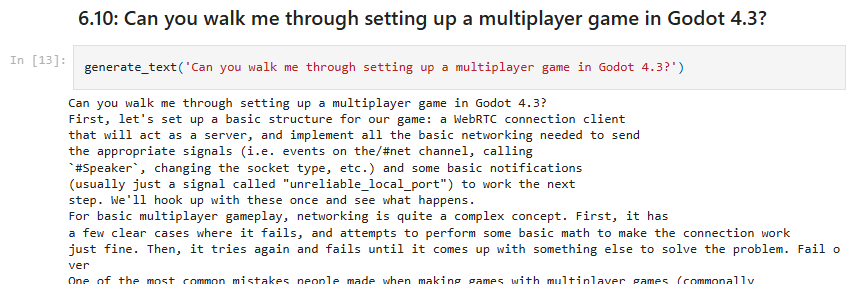

Pretty awesome that some answers were somewhat decent (percentage too small to be happy), but just felt it would fit for the learning to use better models for the future.

## System Used

This was done on older desktop hardware. Windows 10, WSL Ubuntu 22.04, i7 processor, Radeon 3050 8Gb OC, 16Gb RAM.

## Warning:

**Things are changing regularly, so if you try this yourself you will see warnings (if it still runs), mostly to do with deprecation these days.**

## Base Code Use:

Adjusted my training linked above, personally.

# Step 1: Imports

In [ ]:
!pip install -qU tensorflow --break-system-packages

In [1]:
from transformers import Trainer, TrainingArguments

2024-10-09 06:44:59.264212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 06:45:00.013128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 06:45:00.156958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 06:45:01.143870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 06:45:10.655574: W tensorflow/compiler/tf2

# Step 2: Load Dataset

Using [edg3/experiment_software_csharp_12_net_8](https://huggingface.co/datasets/edg3/experiment_software_csharp_12_net_8) for training. It's a dirty dataset I need to clean.

In [ ]:
!pip install -qU datasets --break-system-packages

In [2]:
from datasets import load_dataset

dataset = load_dataset('edg3/experiment_software_csharp_12_net_8')

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'content'],
        num_rows: 12228
    })
    validation: Dataset({
        features: ['title', 'content'],
        num_rows: 1529
    })
    test: Dataset({
        features: ['title', 'content'],
        num_rows: 1529
    })
})

In [4]:
print(dataset['train'][0]['title'])
print(dataset['train'][0]['content'])

20:1
Kubernetes


In [5]:
print(dataset['validation'][0]['title'])
print(dataset['validation'][0]['content'])

4:362
try


I know how I will clean up the dataset, just using it for POC for now...

# Step 3: Load Tokenizer

Using [Deniskin/gpt3_medium](https://huggingface.co/Deniskin/gpt3_medium)

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Deniskin/gpt3_medium")

def tokenize_function(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1529 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [7]:
# Smaller Training Set, if ever wanted
#small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
#small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]

# Step 4: Load model for training

Using [Deniskin/gpt3_medium](https://huggingface.co/Deniskin/gpt3_medium)

(3.14Gb)

In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("Deniskin/gpt3_medium", ignore_mismatched_sizes=True)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at Deniskin/gpt3_medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at Deniskin/gpt3_medium and are newly initialized because the shapes did not match:
- transformer.wte.weight: found shape torch.Size([50257, 1536]) in the checkpoint and torch.Size([50264, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Step 5: Training Hyperparameters

Will use default for now.

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer", report_to=None)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Step 6: Evaluation

The trainer used here doesn't auto evaluate model performance in training. The Hugging Face ```evaluate``` library offers our solution. (TODO: Verify?)

In [15]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Step 7: Train the model

In [17]:
import os
# I didn't want to use wandb
os.environ['WANDB_DISABLED'] = 'true'

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [19]:
%%time
trainer.train()

ValueError: expected sequence of length 7 at dim 1 (got 59)

# Step 8: Test The Model

**TODO: Make this what's actually used, not GPT2...**

In [ ]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer

In [ ]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model

def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

model1_path = "./model"
max_length = 512

model = load_model(model1_path)
tokenizer = load_tokenizer(model1_path)

def Query(sequence):
    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )
    print(tokenizer.decode(final_outputs[0], skip_special_tokens=True))

### 6.1: What’s new in Godot 4.3 compared to previous versions?

In [ ]:
Query('What’s new in Godot 4.3 compared to previous versions?')

### 6.2: Can you explain the changes in the rendering pipeline introduced in Godot 4.3?

In [ ]:
Query('Can you explain the changes in the rendering pipeline introduced in Godot 4.3?')

### 6.3: How do you implement a custom shader in Godot 4.3?

In [ ]:
Query('How do you implement a custom shader in Godot 4.3?')

### 6.4: What are the key differences between GDScript and C# in Godot 4.3?

In [ ]:
Query('What are the key differences between GDScript and C# in Godot 4.3?')

### 6.5: How would you optimize a game for performance in Godot 4.3?

In [ ]:
Query('How would you optimize a game for performance in Godot 4.3?')

### 6.6: Can you describe the process of creating a custom node in Godot 4.3?

In [ ]:
Query('Can you describe the process of creating a custom node in Godot 4.3?')

### 6.7: What are the new features in the animation system of Godot 4.3?

In [ ]:
Query('What are the new features in the animation system of Godot 4.3?')

### 6.8: How do you handle input events in Godot 4.3?

In [ ]:
Query('How do you handle input events in Godot 4.3?')

### 6.9: What are the best practices for using the new navigation system in Godot 4.3?

In [ ]:
Query('What are the best practices for using the new navigation system in Godot 4.3?')

### 6.10: Can you walk me through setting up a multiplayer game in Godot 4.3?

In [ ]:
Query('Can you walk me through setting up a multiplayer game in Godot 4.3?')

### 6.11: How can I use C# to create a procedurally generated 3D chunk in a node in Godot 4.3 on its own?

In [ ]:
Query('How can I use C# to create a procedurally generated 3D chunk in a node in Godot 4.3 on its own?')

### 6.12: How can I make nodes used as chunks, similar to minecraft, to store data in Godot 4.3 so that I can create a synchronous multiplayer world that can be hosted by 1 player, and have a second player connect?

In [ ]:
Query('How can I make nodes used as chunks, similar to minecraft, to store data in Godot 4.3 so that I can create a synchronous multiplayer world that can be hosted by 1 player, and have a second player connect?')

### 6.13: In Godot 4.3, using C#, can you create 2D snake from scratch?

In [ ]:
Query('In Godot 4.3, using C#, can you create 2D snake from scratch?')

# Review (Personal):

- Pending...

# Upload to HuggingFace

In [ ]:
from huggingface_hub import HfApi
from huggingface_hub import create_repo
import os

# Define your model path and repository name
model_path = "model/"
repo_name = "edg3/godot-4.3-gpt3"
my_token = '<your-token-here>' 

if False: # first time true, else repo exists make false
    create_repo(repo_name, token=my_token)

# List all directories inside the model path
folders = [f for f in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, f))]
skip_check = False

# Print the list of folders
if folders and not skip_check:
    print("Folders inside 'model/':")
    for folder in folders:
        print(folder)
else:
    # Initialize the API
    api = HfApi()

    # Upload the model
    api.upload_folder(
        folder_path=model_path,
        repo_id=repo_name,
        commit_message="Second training",
        token=my_token
    )